<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Topic 3: Handling Very Large Arrays, Memory Mappings </h2> 
</center>

_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - April 2017._

In [1]:
%matplotlib inline
%load_ext memory_profiler

import numpy as np
import matplotlib.pyplot as plt
import h5py

def image_plot(img):
    """
    img is an (nx,ny,3) numpy.array
    """
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Para esta actividad trabajaremos con la siguiente imagen astronómica:

In [2]:
img = plt.imread('heic1608b.jpg', format='jpeg')[0:8660,:,:]
print(img.shape)

(8660, 10260, 3)


In [3]:
type(img)

numpy.ndarray

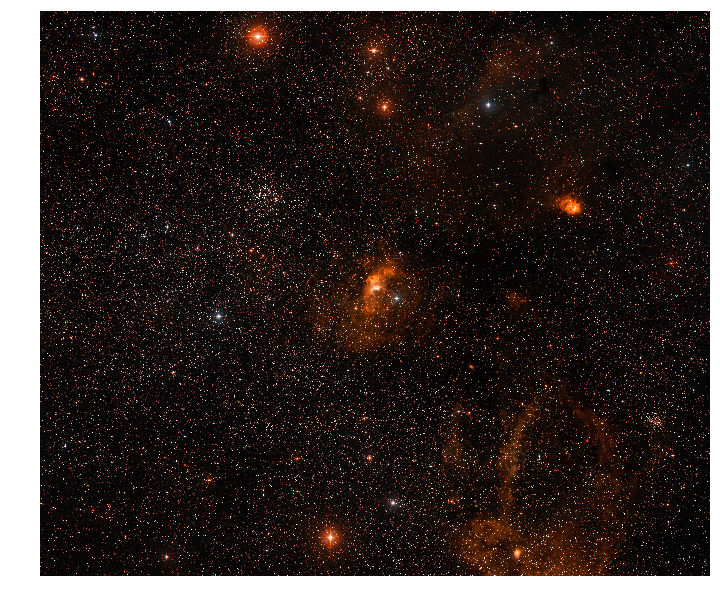

In [4]:
image_plot(img)

#### Paso 1.

1. Guarde `img` en un archivo `hdf5` en el formato que considere conveniente (puede utilizar _chunks_). Explique su elección. 
2. Elimine `img` de memoria principal.

#### Paso 2

1. Aplíque el siguiente filtro/kernel _sin overlap_ a cada canal de la imágen por separado:
```Python
K = 1/25. * np.ones((5,5))
```
2. No puede cargar `img` completamente en memoria. 
3. Realice `timeit` y `memit` del computo anterior.
4. Guarde la imágen resultante. ¿Que fue lo que se le hizo a la imágen original?

#### Paso 3
Muestre la imágen resultante con la función `image_plot()`.

## Solución

### Paso 1.

In [5]:
f = h5py.File("image.h5", "w")

In [6]:
nrows = img.shape[0]
ncols = img.shape[1]
nchan = img.shape[2]
#dset = f.create_dataset("image", (nrows,ncols,nchan), chunks=(50,ncols,nchan), dtype='uint8')
dset = f.create_dataset("image", (nrows,ncols,nchan), dtype='uint8')
dset[:,:,:] = img

In [7]:
del img

Para el almacenamiento se decide utilizar chunks de tamaño `50xncolsx3`, pues se aplicará el filtro de 5 filas en 5 filas por cada canal, logrando de este modo que se carge un `chunk` cada 10 iteraciones. Otra opciones pueden ser: 
1. `chunks` de `5x5x3`, pero con gran cantidad de estos.
2. `chunks` de `5xnrowsx1` para cargar directamente las 5 filas, por no los tres canales.
3. Dejar el almacenamiento por defecto (por filas).

### Paso 2.

In [8]:
K = 1/25. * np.ones((5,5))

In [9]:
res = np.empty((nrows//5, ncols//5, nchan))

In [10]:
%%timeit -n 1
for i in range(0,nrows,5):
    for j in range(0,ncols,5):
        res[i//5, j//5, 0] = round( np.sum(dset[i:i+5,j:j+5,0]*K) )
        res[i//5, j//5, 1] = round( np.sum(dset[i:i+5,j:j+5,1]*K) )
        res[i//5, j//5, 2] = round( np.sum(dset[i:i+5,j:j+5,2]*K) )

1 loop, best of 3: 42min 28s per loop


Lo que se hizo fue hacer una reducción de tamaño en la imágen original (`x25`), almacenando en cada pixel de la imágen reducida, el valor promedio en regiones de `5x5`.

### Paso 3.

In [11]:
res.shape

(1732, 2052, 3)

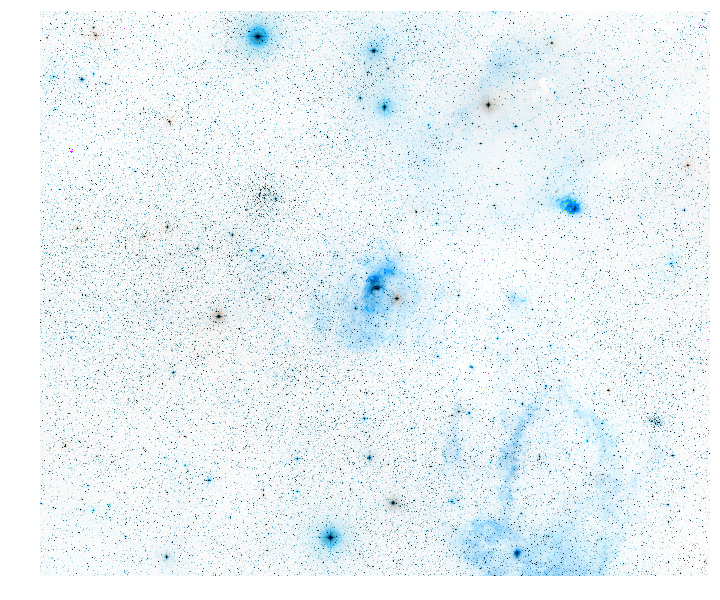

In [12]:
image_plot(res)